In [1]:
import jax
jax.config.update("jax_compilation_cache_dir", "/cluster/scratch/mpundir/jax-cache")
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update('jax_platforms', 'cpu')
import numpy as np

import functools
from jax.typing import ArrayLike
from jax import Array

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools

In [3]:
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.append('../fft_helpers/')
from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])
from plot_helper_for_paper import plot_contourf, plot_imshow, set_size

## constructing a dual phase RVE

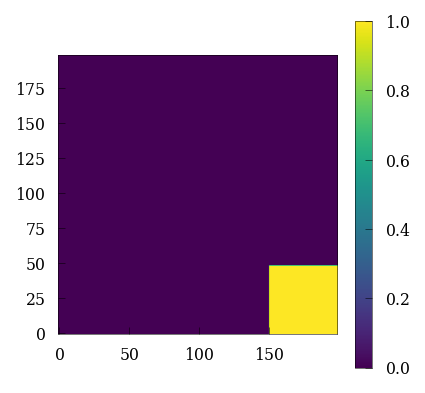

In [5]:
H, L = (199, 199)
Hmid = int(H/2)
Lmid = int(L/2)
r = 49

structure = np.zeros((H, L))
structure[:r, -r:] += rectangle(r, r)

plt.figure(figsize=(3, 3))
cb = plt.imshow(structure, origin='lower')
plt.colorbar(cb)

In [6]:
ndim = len(structure.shape)
N    = structure.shape[0] 

# grid dimensions
shape  = [N, N]         # number of voxels in all directions

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


In [7]:
# identity tensor (single tensor)
i    = jnp.eye(ndim)

# identity tensors (grid)
I    = jnp.einsum('ij,xy'          ,                  i   ,jnp.ones([N,N]))  # 2nd order Identity tensor
I4   = jnp.einsum('ijkl,xy->ijklxy',jnp.einsum('il,jk',i,i),jnp.ones([N,N])) # 4th order Identity tensor
I4rt = jnp.einsum('ijkl,xy->ijklxy',jnp.einsum('ik,jl',i,i),jnp.ones([N,N]))
I4s  = (I4+I4rt)/2.

II   = tensor.dyad22(I,I)

## assigning material parameters 
We assign material parameters to the two phases. The two phases within the RVE are denoted as
- Soft = 0
- Hard = 1

In [8]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=['soft', 'hard'])
def param(X, soft, hard):
    return soft*jnp.ones_like(X)*(X)+hard*jnp.ones_like(X)*(1-X)

In [9]:
# material parameters
shear_modulus = {"hard": 50, "soft": 16}  # N/mm2
jm_modulus = {"hard": 0.2, "soft": 0.4}


In [10]:
# material parameters
μ0     = param(structure,   soft=shear_modulus['soft'],       hard=shear_modulus['hard']        )  # shear     modulus
Jm     = param(structure,   soft=jm_modulus['soft'],          hard=jm_modulus['hard']        )  # shear     modulus

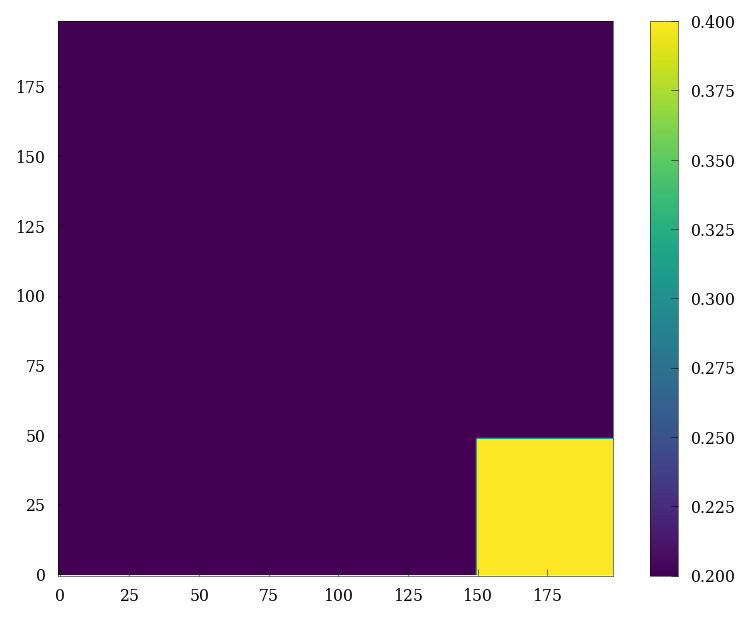

In [11]:
plt.imshow(Jm, origin='lower')
plt.colorbar()

In [12]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,)*ndim, operator='fourier', length=1.)

In [13]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn (jnp.fft.ifftshift(x),[N,N]))

@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x),[N,N]))

# functions for the projection 'G', and the product 'G : K : dF'
@jax.jit
def G(A2):
    return  jnp.real( ifft( tensor.ddot42(Ghat4_2,fft(A2)) ) ).reshape(-1)

@jax.jit
def K_dF(dF, K4):
    #jax.debug.print('x={}', K4)
    return tensor.trans2(tensor.ddot42(K4, tensor.trans2(dF.reshape(ndim,ndim,N,N)) ))

@jax.jit
def G_K_dF(dF, K4):
    return G(K_dF(dF, K4))


## gent material

The strain energy function for a `Gent` material (isotropic compresisble hyperelastic material) is given as 
\begin{align}
    \psi = -\dfrac{\mu}{2} \left( J_m \ln \left( 1 - \dfrac{I_1 - 3}{J_m} \right) + 2 \ln(J) \right)
\end{align}

where $I_1 = \text{tr}(B) =  \text{tr}(F^T.F)$ $B$ is the left Cauchy Green deformation gradient

where $J = \text{det}(F)$ is the determinant of deformation gradient

where `E= Green-Lagrange strain tensor` which can be related to the `deformation gradient F` as 
\begin{align}
E = \dfrac{1}{2}(F^{T}.F -I)
\end{align}

In [14]:

# determinant of grid of 2nd-order tensors
@jax.jit
def det2(A2):
    return A2.at[0,0].get()*A2.at[1,1].get() - A2.at[0,1].get()*A2.at[1,0].get()

@jax.jit
def left_cauchy_green_deformation_tensor(F : ArrayLike) -> Array:
    return tensor.dot22(tensor.trans2(F),F)

@jax.jit
def strain_energy(F : ArrayLike) -> Array:
    B = left_cauchy_green_deformation_tensor(F)
    J = det2(F)
    I1 = tensor.trace2(B)
    energy = -jnp.multiply(μ0/2., jnp.multiply(Jm, jnp.log(1 - jnp.divide(I1 - 3, Jm)) + 2*jnp.log(J)))
    return energy.sum()

piola_kirchhoff = jax.jit(jax.jacrev(strain_energy))

Due to the `geometric nonlinearity` in the stress-strain relationship, we use a `Netwon-Raphson` scheme combined with `Conjugate gradient` to solve for the compatible strains within the RVE. 
\begin{align}
    \Delta \sigma_{ij} = \dfrac{\partial \sigma_{ij}(F)}{\partial F_{ij}}\Delta F_{ij}
\end{align}

In [15]:
@functools.partial(jax.jit, static_argnames=['piola_kirchhoff'])
def G_P(dF, additional, piola_kirchhoff):
    dF = dF.reshape(ndim,ndim,N,N)
    tangents = jax.jvp(piola_kirchhoff, (additional,), (dF,))[1] ## to compute the jvp at F in the direction of dF to get the correct incremental stress
    return G(tangents)

In [16]:
@functools.partial(jax.jit, static_argnames=['A', 'K'])
def conjugate_gradient(A, b, additional, K,  atol=1e-5):

    b, additional = jax.device_put((b, additional))

    def body_fun(state):
        b, p, r, rsold, x =  state
        Ap = A(p, additional, K) 
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r) 
        p = r + (rsnew/rsold)*p
        rsold = rsnew
        return (b, p, r, rsold, x)

    def cond_fun(state):
        b, p, r, rsold, x = state
        return jnp.sqrt(rsold) > atol

    x = jnp.zeros_like(b)
    r = b - A(x, additional, K)
    p = r
    rsold = jnp.vdot(r, r) 
    
    b, p, r, rsold, x = jax.lax.while_loop(cond_fun, body_fun, (b, p, r, rsold, x) )
    return x

## newton raphson method

Here we define a function to solve the hyperelasticity problem using a `newton-raphson` method

In [17]:
@jax.jit
def solve_netwon_raphson(state, n):
    dF, b, F, Fn = state

    error = jnp.linalg.norm(dF)/Fn
    jax.debug.print('residual={}', error)
       
    def true_fun(state):
        dF, b, F, Fn = state

        dF = conjugate_gradient(
                atol=1e-8, 
                A = G_P,
                b = b,
                additional= F,
                K=piola_kirchhoff,
        )                                   # solve linear system using CG

        dF     = dF.reshape(ndim,ndim,N,N)
        F      = jax.lax.add(F, dF)         # update DOFs (array -> tens.grid)
        P      = piola_kirchhoff(F)         # new residual stress
        b      = -G(P)                      # convert residual stress to residual

        return (dF,  b, F, Fn)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-5, true_fun, false_fun, state), n

## solving for a given loaded state 

In [18]:
F = jnp.array(I, copy=True)
P = piola_kirchhoff(F)

# set macroscopic loading
DbarF = jnp.zeros([ndim,ndim,N,N])
DbarF = DbarF.at[0, 1].set(1e-1)

# initial residual: distribute "barF" over grid using "K4"
b     = -G_P(DbarF, F, piola_kirchhoff)
F     = jax.lax.add(F, DbarF) 
Fn    = jnp.linalg.norm(F)

In [19]:
state = (DbarF, b, F, Fn)
initial_state = jax.device_put(state)

In [20]:
final_state, xs = jax.lax.scan(solve_netwon_raphson, 
                               init=initial_state, 
                               xs=jnp.arange(0, 10))

residual=0.0705345615858598
residual=0.008470035538537467
residual=0.0015565804971452296
residual=7.856409318335205e-06
residual=7.856409318335205e-06
residual=7.856409318335205e-06
residual=7.856409318335205e-06
residual=7.856409318335205e-06
residual=7.856409318335205e-06
residual=7.856409318335205e-06


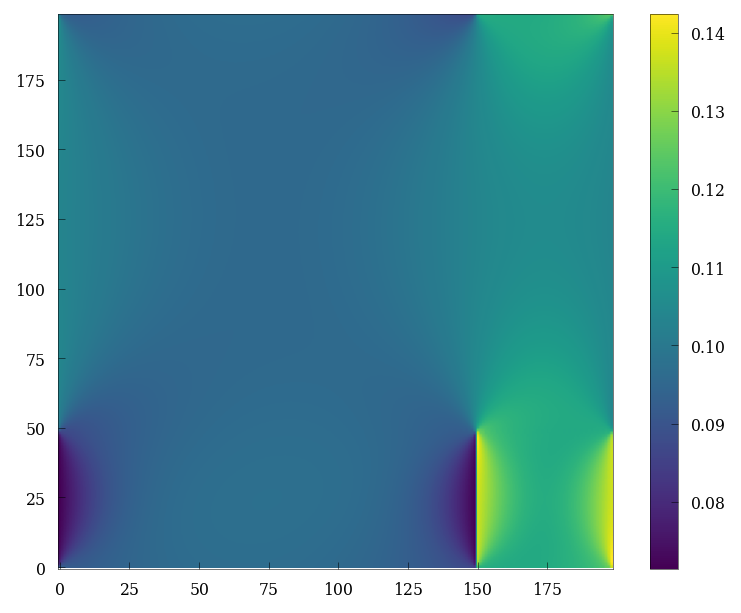

In [21]:
plt.imshow(final_state[2].at[0, 1].get(), origin='lower')
plt.colorbar()

In [31]:
@jax.jit
def local_constitutive_update(macro_strain):

    # ----------------------------- NEWTON ITERATIONS -----------------------------
    # initialize stress and strain tensor                         [grid of tensors]
    #eps      = jnp.zeros([ndim,ndim,N,N])
    eps  =  jnp.array(I, copy=True)
    # set macroscopic loading
    DE       = jnp.zeros([ndim,ndim,N,N])
    DE = DE.at[0, 0].set(macro_strain[0, 0])
    DE = DE.at[1, 1].set(macro_strain[1, 1])
    DE = DE.at[0, 1].set(macro_strain[0, 1])
    DE = DE.at[1, 0].set(macro_strain[1, 0])

    # initial residual: distribute "DE" over grid using "K4"
    b        = -G_P(DE, eps, piola_kirchhoff)
    eps      = jax.lax.add(eps, DE) 
    En       = jnp.linalg.norm(eps)

    state = (DE, b, eps, En)
    initial_state = jax.device_put(state)

    final_state, xs = jax.lax.scan(solve_netwon_raphson, 
                               init=initial_state, 
                               xs=jnp.arange(0, 10))
    

    DE, b, eps, En = final_state
    P = piola_kirchhoff(eps)

    # get the macro stress
    macro_sigma = jnp.array([jnp.mean(P.at[0, 0].get()), jnp.mean(P.at[1, 1].get()), jnp.mean(P.at[0, 1].get())])

    return jnp.array( [[macro_sigma.at[0].get(), macro_sigma.at[2].get()/2.],[macro_sigma.at[2].get()/2., macro_sigma.at[1].get()]] ), (macro_sigma, P, eps)

In [32]:
tangent_operator_and_state = jax.jacfwd(
    local_constitutive_update, argnums=0, has_aux=True
)

In [33]:
deps = jnp.array([[1e-3, 0], [0, 2e-3]])

In [38]:
import timeit

In [39]:
start = timeit.default_timer()
tangent, state = tangent_operator_and_state(deps)
print(timeit.default_timer()-start)

residual=0.0015787704773174971
residual=0.00026910167792174754
residual=0.001276752994205467
residual=5.049238385397511e-06
residual=5.049238385397511e-06
residual=5.049238385397511e-06
residual=5.049238385397511e-06
residual=5.049238385397511e-06
residual=5.049238385397511e-06
residual=5.049238385397511e-06
6.844096690008882


In [35]:
tangent

Array([[[[ 3.11166606e+01, -3.87558978e-17],
         [-1.36363344e-16,  1.33568329e+01]],

        [[-1.43540362e-18,  4.02346502e+00],
         [ 4.82959902e+00, -7.17701811e-19]]],


       [[[-1.43540362e-18,  4.02346502e+00],
         [ 4.82959902e+00, -7.17701811e-19]],

        [[ 1.33568329e+01, -7.03347775e-17],
         [-1.30621730e-16,  3.11245167e+01]]]], dtype=float64)

In [36]:
state[0]

Array([-1.62359708e+00, -1.60583333e+00, -3.81279087e-19], dtype=float64)

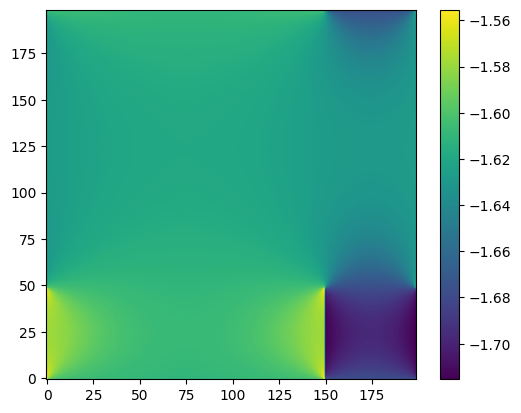

In [27]:
plt.imshow(state[1].at[0, 0].get(), origin='lower')
plt.colorbar()

In [28]:
tangents = []
deformations = np.linspace(1e-4, 1e-1, num=10)
for dep in deformations:
    deps = jnp.array([dep, dep/10., 0])
    tangent, state = tangent_operator_and_state(deps)
    tangents.append(tangent)

residual=7.105944367641367e-05
residual=1.1254206496892181e-05
residual=0.0012846588038883855
residual=4.994098703763459e-06
residual=4.994098703763459e-06
residual=4.994098703763459e-06
residual=4.994098703763459e-06
residual=4.994098703763459e-06
residual=4.994098703763459e-06
residual=4.994098703763459e-06
residual=0.007910268322101562
residual=0.001228210428898748
residual=0.001265443412756214
residual=5.341406599003363e-06
residual=5.341406599003363e-06
residual=5.341406599003363e-06
residual=5.341406599003363e-06
residual=5.341406599003363e-06
residual=5.341406599003363e-06
residual=5.341406599003363e-06
residual=0.015654348281605543
residual=0.002379548977299753
residual=0.0012826900693592355
residual=6.030296584612204e-06
residual=6.030296584612204e-06
residual=6.030296584612204e-06
residual=6.030296584612204e-06
residual=6.030296584612204e-06
residual=6.030296584612204e-06
residual=6.030296584612204e-06
residual=0.023304471799337402
residual=0.003462975697077963
residual=0.001

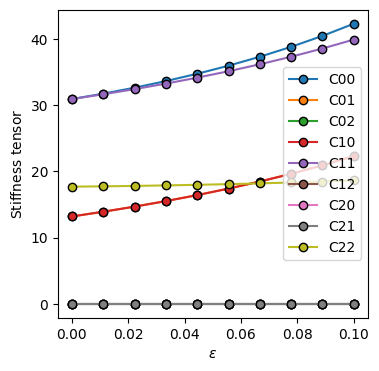

In [29]:
plt.figure(figsize=(4, 4))
for i in range(0, 3):
    for j in range(0, 3):
        C = [tang[i, j] for tang in tangents]
        plt.plot(deformations, C, marker='o', label=f"C{i}{j}", markeredgecolor='k')

plt.ylabel(r'$\text{Stiffness tensor}$')
plt.xlabel(r'$\varepsilon$')
plt.legend()
plt.savefig('./figs/paper_gent_tangent_stiffness.pdf', dpi=200)
plt.show()